In [2]:
import numpy as np
import numpy.matlib as mt
import h5py
import math 
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import align_trials
from ephysvibe.task import task_constants

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy import signal,stats

import os 
from matplotlib import cm
from matplotlib import pyplot as plt
import glob
from pathlib import Path
import pickle

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import permutations
seed = 2023


In [3]:

def scale_p(x, out_range=(-1, 1)):
    if np.sum(x>1) >0:
        return
    domain = 0, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2



In [4]:
def compute_roc_auc(group1,group2):
    rng = np.random.default_rng(seed=seed)
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]

        # Wilcoxon rank-sum 
        p.append(stats.ranksums(g1, g2)[1])#stats.ttest_ind

        thresholds = np.unique(np.concatenate([g1,g2]))

        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
                      
            score = metrics.auc(fpr[fpr.argsort()],tpr[fpr.argsort()])
        roc_score.append(score)
        
    roc_score = np.array(roc_score)
    p=np.array(p)
    
    roc_score = scale_p(np.round(roc_score,2),out_range=[-1,1])
    
    return roc_score, p


In [5]:
def perm_single_trials(acti):    
    scrumbled  =   np.random.permutation(acti)
    diff   =   acti-scrumbled
    return diff

In [6]:
def trial_latency(test_data):
    values=[11,15,51,55]
    for test in values:
        globals()['stim_vis_'+ str(test) +'_in']    =   basic_cond(test_data=test_data, sample_value=-1, test_value=test, position=1)
        globals()['stim_vis_'+ str(test)+'_out']    =   basic_cond(test_data=test_data, sample_value=-1, test_value=test, position=-1)
        for sample in values:
            globals()['s_in_'+str(sample)+'_t_'+ str(test)]  =   basic_cond(test_data=test_data, sample_value=sample, test_value=test, position=1)
            globals()['s_out_'+str(sample)+'_t_'+ str(test)] =   basic_cond(test_data=test_data, sample_value=sample, test_value=test, position=-1)


    stim_match_in   =   np.sort(np.concatenate([s_in_11_t_11, s_in_15_t_15, s_in_51_t_51, s_in_55_t_55]))
    stim_match_out  =   np.sort(np.concatenate([s_out_11_t_11, s_out_15_t_15, s_out_51_t_51, s_out_55_t_55]))

    rts_in     =   test_data['reaction times'][stim_match_in]
    rts_out    =   test_data['reaction times'][stim_match_out]

    acti_match_in   =   test_data['averaged data'][stim_match_in,:-100]
    diff_in            =   np.empty([1000, acti_match_in.shape[1]],dtype='single')
    sig_in             =   np.empty([acti_match_in.shape[0], acti_match_in.shape[1]],dtype='single')
    lat_in             =   np.empty(acti_match_in.shape[0],dtype='single')*np.nan

    acti_match_out  =   test_data['averaged data'][stim_match_out,:-100]
    diff_out        =   np.empty([1000,  acti_match_out.shape[1]],dtype='single')
    sig_out         =   np.empty([acti_match_out.shape[0], acti_match_out.shape[1]],dtype='single')
    lat_out         =   np.empty(acti_match_out.shape[0],dtype='single')*np.nan
    
    # define a latency for each trial using time permutation
    m=np.max([acti_match_in.shape[0], acti_match_out.shape[0]])  

    for trial in range(m):
        if trial<acti_match_in.shape[0] and trial<acti_match_out.shape[0]:
            for it in range(1000):
            
                scrumbled_in  =   np.random.permutation(acti_match_in[trial,:])
                diff_in[it,:]    =   acti_match_in[trial,:]-scrumbled_in

                scrumbled_out  =   np.random.permutation(acti_match_out[trial,:])
                diff_out[it,:]    =   acti_match_out[trial,:]-scrumbled_out
            
            sig_in[trial,:]=np.sum(diff_in>0, axis=0)
            sig_out[trial,:]=np.sum(diff_out>0, axis=0)

            if np.sum(sig_in[trial,:]>950)>0:
                lat_in[trial]=np.where(sig_in[trial,:]>950)[0][0]
            if np.sum(sig_out[trial,:]>950)>0:
                lat_out[trial]=np.where(sig_out[trial,:]>950)[0][0]


        if trial>=acti_match_in.shape[0] and trial<acti_match_out.shape[0]:
            for it in range(1000):    
                scrumbled_out  =   np.random.permutation(acti_match_out[trial,:])
                diff_out[it,:]    =   acti_match_out[trial,:]-scrumbled_out
            
            sig_out[trial,:]=np.sum(diff_out>0, axis=0)
            if np.sum(sig_out[trial,:]>950)>0:
                lat_out[trial]=np.where(sig_out[trial,:]>950)[0][0]

        if trial<acti_match_in.shape[0] and trial>=acti_match_out.shape[0]:
            for it in range(1000): 
                scrumbled_in  =   np.random.permutation(acti_match_in[trial,:])
                diff_in[it,:]    =   acti_match_in[trial,:]-scrumbled_in
            
            sig_in[trial,:]=np.sum(diff_in>0, axis=0)
            if np.sum(sig_in[trial,:]>950)>0:
                lat_in[trial]=np.where(sig_in[trial,:]>950)[0][0]
            
    lat_sel_in=lat_in[np.logical_and(lat_in>0, rts_in>0)]
    rts_sel_in=rts_in[np.logical_and(lat_in>0, rts_in>0)]

    if np.sum(len(lat_sel_in>0))>10:
        rin, pin= stats.pearsonr(lat_sel_in, rts_sel_in)
    else:
        rin, pin= [np.nan, np.nan]

    lat_sel_out=lat_out[np.logical_and(lat_out>0, rts_out>0)]
    rts_sel_out=rts_out[np.logical_and(lat_out>0, rts_out>0)]
    if np.sum(len(lat_sel_out>0))>10:
        rout, pout= stats.pearsonr(lat_sel_out, rts_sel_out)        
    else:
        rout, pout= [np.nan, np.nan]

    results={"name": test_data['name'],
             "corr coef match in": rin,
             "p value match in": pin,
             "corr coef match out": rout,
             "p value match out": pout}
    
    return results

In [14]:
with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/lip_test_avg_w50_s1m300p500_corrcoef', 'rb') as handle:
    test_lip_avg_corr = pickle.load(handle)

# with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/lip_test_zsc_w50_s1m300p500', 'rb') as handle:
#     test_lip_zsc = pickle.load(handle)

# with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/lip_test_cond', 'rb') as handle:
#     test_lip_cond = pickle.load(handle)

In [15]:
test_lip_avg_corr

[{'name': '2022-12-01_good_1',
  'corr coef match in': 0.009282866207290047,
  'p value match in': 0.9374331868127531,
  'corr coef match out': -0.11108814951039095,
  'p value match out': 0.3427050330997871},
 {'name': '2022-12-01_good_2',
  'corr coef match in': -0.0649894328382131,
  'p value match in': 0.7977945833194168,
  'corr coef match out': 0.12979478756278112,
  'p value match out': 0.494222744651607},
 {'name': '2022-12-01_mua_1',
  'corr coef match in': -0.3642955374280173,
  'p value match in': 0.05666793341158388,
  'corr coef match out': -0.20337491890963796,
  'p value match out': 0.38979085873254143},
 {'name': '2022-12-01_good_3',
  'corr coef match in': 0.4422922877313246,
  'p value match in': 0.002646244484560821,
  'corr coef match out': 0.057820882848155786,
  'p value match out': 0.6319667075904296},
 {'name': '2022-12-01_good_4',
  'corr coef match in': -0.03809642545993143,
  'p value match in': 0.8629836041830016,
  'corr coef match out': -0.3514662150687466

In [21]:
with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/pfc_test_avg_w50_s1m300p500_corrcoef', 'rb') as handle:
    test_pfc_avg_corr = pickle.load(handle)
    

In [ ]:

with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/v4_test_avg_w50_s1m300p500_corrcoef', 'rb') as handle:
    test_v4_avg = pickle.load(handle)

In [6]:
# with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/v4_test_avg_w50_s1m300p500', 'rb') as handle:
#     test_v4_avg = pickle.load(handle)

with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/v4_test_avg_w50_s1m300p500', 'rb') as handle:
    test_v4_avg = pickle.load(handle)

In [41]:

with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/v4_test_zsc_50_s1m300p500', 'rb') as handle:
    test_v4_zsc = pickle.load(handle)

MemoryError: 

In [7]:
def even_trials(test_data, match, no_match):

    pos_match       =   test_data['test num'][match]
    
    nomatch_test_num    =   test_data['test num'][no_match]

    num_nomatch_0   =   np.sum(nomatch_test_num==0)
    proportion_nomatch_0    =   num_nomatch_0/no_match.shape[0]
    tmp_match_0  =   np.random.permutation(match[pos_match==0])
    
    num_nomatch_1   =   np.sum(nomatch_test_num==1)
    proportion_nomatch_1    =   num_nomatch_1/no_match.shape[0]
    tmp_match_1  =   np.random.permutation(match[pos_match==1])
    
    num_nomatch_2   =   np.sum(nomatch_test_num==2)
    proportion_nomatch_2    =   num_nomatch_2/no_match.shape[0]
    tmp_match_2  =   np.random.permutation(match[pos_match==2])
    
    
    num_nomatch_3   =   np.sum(nomatch_test_num==3)
    proportion_nomatch_3    =   num_nomatch_3/no_match.shape[0]
    tmp_match_3  =   np.random.permutation(match[pos_match==3])
    
    
    num_nomatch_4   =   np.sum(nomatch_test_num==4)
    proportion_nomatch_4    =   num_nomatch_4/no_match.shape[0]
    tmp_match_4  =   np.random.permutation(match[pos_match==4])
    

    # tmp_match_n0 =   np.random.permutation(match[pos_match>0])

    num0    =   np.round(tmp_match_0.shape[0]*proportion_nomatch_0)
    num1    =   np.round(tmp_match_1.shape[0]*proportion_nomatch_1)
    num2    =   np.round(tmp_match_2.shape[0]*proportion_nomatch_2)
    num3    =   np.round(tmp_match_3.shape[0]*proportion_nomatch_3)
    num4    =   np.round(tmp_match_4.shape[0]*proportion_nomatch_4)
    # numn0   =   np.round(tmp_match_n0.shape[0]*(1-proportion_nomatch_0))

    match_trials    =   np.concatenate([tmp_match_0[:int(num0)],tmp_match_1[:int(num1)],tmp_match_2[:int(num2)],tmp_match_3[:int(num3)],tmp_match_4[:int(num4)] ])

    return match_trials

In [12]:
test_lip_avg[i]

{'name': '2022-12-01_mua_1',
 'averaged data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'sample id': array([55., 15., 11., 11., 51., 15., 51.,  0., 55., 11.,  0., 51.,  0.,
        55., 11., 15., 11., 15.,  0.,  0., 11., 15., 15., 51., 55., 11.,
        51., 15., 11.,  0., 51., 15., 11., 11.,  0.,  0.,  0., 15., 11.,
        55., 11., 11.,  0., 55.,  0., 55.,  0., 11., 51.,  0., 55., 51.,
        15., 15.,  0.,  0., 15., 55., 15., 11., 15., 51.,  0., 15., 55.,
        11., 51.,  0., 15., 11., 11.,  0., 51., 11., 15., 51., 15., 55.,
         0.,  0., 15.,  0., 15.,  0., 51., 11., 11., 11., 15.,  0., 55.,
        15., 11., 11., 15.,  0., 15., 15., 15., 55., 55.,  0., 55.,  0.,
        11., 51., 55., 11., 15., 11., 51., 11., 51.,  0., 11., 51., 15.,
        15., 11., 11., 51.,  0., 11

In [24]:
pfc_cor_coef_in     =   []
pfc_cor_pva_in      =   []

pfc_cor_coef_out    =   []
pfc_cor_pva_out     =   []

lip_cor_coef_in     =   []
lip_cor_pva_in      =   []

lip_cor_coef_out    =   []
lip_cor_pva_out     =   []

lip_cor_coef_in=[]
for i in range(len(test_pfc_avg_corr)):
    pfc_cor_coef_in.append(test_pfc_avg_corr[i]['corr coef match in'])
    pfc_cor_pva_in.append(test_pfc_avg_corr[i]['p value match in'])
    pfc_cor_coef_out.append(test_pfc_avg_corr[i]['corr coef match out'])
    pfc_cor_pva_out.append(test_pfc_avg_corr[i]['p value match out'])

    if i<len(test_lip_avg_corr):
        lip_cor_coef_in.append(test_lip_avg_corr[i]['corr coef match in'])
        lip_cor_pva_in.append(test_lip_avg_corr[i]['p value match in'])
        lip_cor_coef_out.append(test_lip_avg_corr[i]['corr coef match out'])
        lip_cor_pva_out.append(test_lip_avg_corr[i]['p value match out'])


In [23]:
test_pfc_avg_corr

[{'name': '2022-12-01_mua_1',
  'corr coef match in': -0.5503007314577923,
  'p value match in': 0.004368856778769711,
  'corr coef match out': -0.40129509998403834,
  'p value match out': 0.0001700111478247117},
 {'name': '2022-12-01_mua_2',
  'corr coef match in': -0.09968509907351067,
  'p value match in': 0.378982783470931,
  'corr coef match out': 0.10586748647448069,
  'p value match out': 0.42078413350599136},
 {'name': '2022-12-01_mua_3',
  'corr coef match in': -0.14770426023968913,
  'p value match in': 0.22237488312025244,
  'corr coef match out': -0.015135146964449397,
  'p value match out': 0.8674955424370073},
 {'name': '2022-12-01_mua_4',
  'corr coef match in': -0.0897260252496875,
  'p value match in': 0.5671923053420307,
  'corr coef match out': -0.04462830752275443,
  'p value match out': 0.7371504154600613},
 {'name': '2022-12-01_mua_5',
  'corr coef match in': -0.2923258001528631,
  'p value match in': 0.018130391656998254,
  'corr coef match out': -0.2819743976657

In [45]:
lip_cor_coef_in=np.array(lip_cor_coef_in)
pfc_cor_coef_in=np.array(pfc_cor_coef_in)

lip_cor_coef_out=np.array(lip_cor_coef_out)
pfc_cor_coef_out=np.array(pfc_cor_coef_out)

In [42]:
h,p=stats.ttest_ind(lip_cor_coef_in[lip_cor_coef_in>0], pfc_cor_coef_in[pfc_cor_coef_in>0])
print(h,p)

7.546256971966132 8.853005084980852e-14


In [48]:
pfc_cor_coef_out[incl]

array([-4.46283075e-02, -2.23354702e-01, -1.85583805e-02,             nan,
       -1.24683385e-02,  5.57558639e-02,  7.36183447e-02, -1.62532747e-01,
        2.37062919e-01,             nan,             nan,  1.21137045e-01,
                   nan,  2.38731705e-02,             nan, -7.15395249e-02,
        1.49722259e-01, -9.10851460e-02,  1.23923979e-01,  3.04974460e-02,
       -1.39452617e-01,  4.61253245e-01,  1.80828122e-01,  2.78836827e-01,
        4.51189480e-02,  1.25709260e-02,  7.27709105e-02, -1.80678414e-01,
       -1.63003897e-01, -9.03023180e-02,  1.44914599e-01, -2.33018708e-01,
                   nan, -1.02892530e-01,  1.71843958e-01,             nan,
       -5.07803504e-02, -1.30315602e-01,  4.22751331e-02,  5.38889077e-02,
        1.60900586e-01,  8.20305646e-02,  2.40027027e-01,  1.30498849e-01,
       -1.94032847e-01,  8.49172913e-02, -1.00013389e-01, -3.66997112e-01,
        9.94065960e-02, -2.31543482e-01, -1.00005806e-01,  5.22235681e-01,
        1.79626277e-02,  

In [49]:
incl=np.where(np.logical_and(lip_cor_coef_in>0, lip_cor_coef_out>0))
h,p=stats.ttest_rel(lip_cor_coef_in[incl], lip_cor_coef_out[incl])
print(h,p)

0.15535186452674765 0.8768286462146906


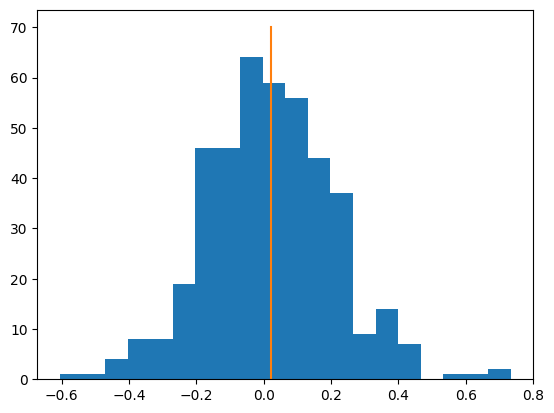

In [33]:
plt.hist(lip_cor_coef_in, 20)
plt.plot([np.nanmean(lip_cor_coef_in), np.nanmean(lip_cor_coef_in)], [0,70])

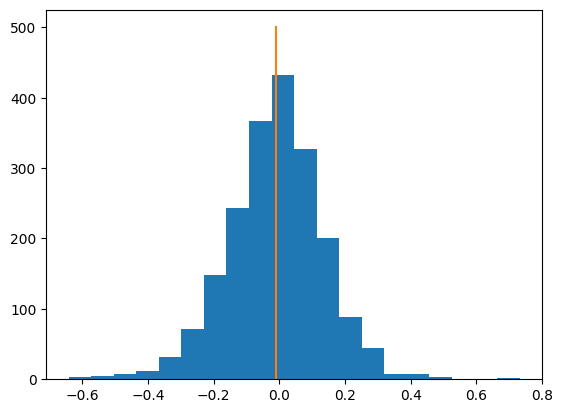

In [35]:
plt.hist(pfc_cor_coef_in, 20)
plt.plot([np.nanmean(pfc_cor_coef_in), np.nanmean(pfc_cor_coef_in)], [0,500])

'2023-11-17_mua_11'

In [11]:
def basic_cond(test_data, sample_value, test_value, position):
    if sample_value>=0:
        result=np.where(np.logical_and(np.logical_and(test_data['sample id']==sample_value, test_data['test id']==test_value), test_data['sample pos']==position))[0]
    else:
        result=np.where(np.logical_and(np.logical_and(test_data['sample id']!=0, test_data['test id']==test_value), test_data['sample pos']==position))[0]
    return result


In [ ]:
# r_in    =   []
# p_in    =   []
# r_out   =   []
# p_out   =   []
# roc_match_in    =   []
# roc_match_out    =   []
# p_match_in    =   []
# p_match_out    =   []

# for i in range(len(test_lip_zsc)):
i=0
test_data=test_lip_zsc[i]
test_datab=test_lip_avg[i]
values=[11,15,51,55]
for test in values:
    globals()['stim_vis_'+ str(test) +'_in']   =   basic_cond(test_data=test_datab, sample_value=-1, test_value=test, position=1)
    globals()['stim_vis_'+ str(test)+'_out']  =   basic_cond(test_data=test_datab, sample_value=-1, test_value=test, position=-1)
    for sample in values:
        globals()['s_in_'+str(sample)+'_t_'+ str(test)]  =   basic_cond(test_data=test_datab, sample_value=sample, test_value=test, position=1)
        globals()['s_out_'+str(sample)+'_t_'+ str(test)] =   basic_cond(test_data=test_datab, sample_value=sample, test_value=test, position=-1)

stim_match_1155_in      =   np.sort(np.concatenate([s_in_11_t_11, s_in_55_t_55]))
stim_nomatch_1155_in    =   np.sort(np.concatenate([s_in_15_t_11, s_in_51_t_11,s_in_55_t_11,
                                                    s_in_11_t_55, s_in_15_t_55,s_in_51_t_55]))

stim_match_1551_in     =   np.sort(np.concatenate([s_in_15_t_15, s_in_51_t_51]))
stim_nomatch_1551_in   =   np.sort(np.concatenate([s_in_11_t_15, s_in_51_t_15, s_in_55_t_15,
                                                s_in_11_t_51, s_in_15_t_51,s_in_55_t_51]))

stim_match_in    =   np.sort(np.concatenate([s_in_11_t_11, s_in_15_t_15, s_in_51_t_51, s_in_55_t_55]))
stim_nomatch_in  =   np.sort(np.concatenate([s_in_11_t_15, s_in_11_t_51,s_in_11_t_55,
                                            s_in_15_t_11, s_in_15_t_51,s_in_15_t_55,
                                            s_in_51_t_11, s_in_51_t_15,s_in_51_t_55,
                                            s_in_55_t_11, s_in_55_t_15,s_in_55_t_51]))

roc_vis_1155_zs_in, p_vis_1155_zs_in        =   compute_roc_auc(test_data['zscored data'][stim_vis_11_in, :], test_data['zscored data'][stim_vis_55_in, :])
roc_match_1155_zs_in, p_match_1155_zs_in    =   compute_roc_auc(test_data['zscored data'][stim_match_1155_in, :], test_data['zscored data'][stim_nomatch_1155_in, :])

roc_vis_1551_zs_in, p_vis_1551_zs_in        =   compute_roc_auc(test_data['zscored data'][stim_vis_15_in, :], test_data['zscored data'][stim_vis_51_in, :])
roc_match_1551_zs_in, p_match_1551_zs_in    =   compute_roc_auc(test_data['zscored data'][stim_match_1551_in, :], test_data['zscored data'][stim_nomatch_1551_in, :])

roc_match_zs_in, p_match_zs_in  =   compute_roc_auc(test_data['zscored data'][stim_match_in, :], test_data['zscored data'][stim_nomatch_in, :])

# OUT

stim_match_1155_out      =   np.sort(np.concatenate([s_out_11_t_11, s_out_55_t_55]))
stim_nomatch_1155_out    =   np.sort(np.concatenate([s_out_15_t_11, s_out_51_t_11,s_out_55_t_11,
                                                    s_out_11_t_55, s_out_15_t_55,s_out_51_t_55]))

stim_match_1551_out     =   np.sort(np.concatenate([s_out_15_t_15, s_out_51_t_51]))
stim_nomatch_1551_out   =   np.sort(np.concatenate([s_out_11_t_15, s_out_51_t_15, s_out_55_t_15,
                                                s_out_11_t_51, s_out_15_t_51,s_out_55_t_51]))

stim_match_out    =   np.sort(np.concatenate([s_out_11_t_11, s_out_15_t_15, s_out_51_t_51, s_out_55_t_55]))
stim_nomatch_out  =   np.sort(np.concatenate([s_out_11_t_15, s_out_11_t_51,s_out_11_t_55,
                                            s_out_15_t_11, s_out_15_t_51,s_out_15_t_55,
                                            s_out_51_t_11, s_out_51_t_15,s_out_51_t_55,
                                            s_out_55_t_11, s_out_55_t_15,s_out_55_t_51]))

roc_vis_1155_zs_out, p_vis_1155_zs_out        =   compute_roc_auc(test_data['zscored data'][stim_vis_11_out, :], test_data['zscored data'][stim_vis_55_out, :])
roc_match_1155_zs_out, p_match_1155_zs_out    =   compute_roc_auc(test_data['zscored data'][stim_match_1155_out, :], test_data['zscored data'][stim_nomatch_1155_out, :])

roc_vis_1551_zs_out, p_vis_1551_zs_out        =   compute_roc_auc(test_data['zscored data'][stim_vis_15_out, :], test_data['zscored data'][stim_vis_51_out, :])
roc_match_1551_zs_out, p_match_1551_zs_out    =   compute_roc_auc(test_data['zscored data'][stim_match_1551_out, :], test_data['zscored data'][stim_nomatch_1551_out, :])

roc_match_zs_out, p_match_zs_out  =   compute_roc_auc(test_data['zscored data'][stim_match_out, :], test_data['zscored data'][stim_nomatch_out, :])

# roc_in, pr_in      =   compute_roc_auc(test_data['zscored data'][stim_match_in, 300+50:300+250], test_data['zscored data'][stim_nomatch_in, 300+50:300+250])
# roc_out, pr_out    =   compute_roc_auc(test_data['zscored data'][stim_match_out, 300+50:300+250], test_data['zscored data'][stim_nomatch_out, 300+50:300+250])

# roc_match_in.append(roc_in)
# roc_match_out.append(roc_out)
# p_match_in.append(pr_in)
# p_match_out.append(pr_out)

acti    =   np.mean(test_data['zscored data'][stim_match_in,300+50:300+250], axis=1)
rts     =   test_data['reaction times'][stim_match_in]

r, p= stats.pearsonr(acti[rts>0], rts[rts>0])
# r_in.append(r)
# p_in.append(p)


acti    =   np.mean(test_data['zscored data'][stim_match_out,300+50:300+250], axis=1)
rts     =   test_data['reaction times'][stim_match_out]
r, p    =   stats.pearsonr(acti[rts>0], rts[rts>0])
# r_out.append(r)
# p_out.append(p)
# r_in=np.array(r_in)
# r_out=np.array(r_out)
# p_in=np.array(p_in)
# p_out=np.array(p_out)

In [37]:
test_lip_avg[0]['reaction times']

array([374., 313.,  nan, ...,  nan,  nan,  nan])

In [12]:
rtcor    =   Parallel(n_jobs = -1)(delayed(trial_latency)(test_v4_avg[cell]) for cell in range(len(test_v4_avg)))
# r_in=[]
# p_in=[]
# r_out=[]
# p_out=[]
# for i in range(len(rtcor)):
#     r_in.append(rtcor[i][0])
#     p_in.append(rtcor[i][1])
#     r_out.append(rtcor[i][2])
#     p_out.append(rtcor[i][3])

IndexError: index 124 is out of bounds for axis 0 with size 124

In [14]:
cell=0

In [15]:
test_data=test_v4_avg[cell]

values=[11,15,51,55]
for test in values:
    globals()['stim_vis_'+ str(test) +'_in']    =   basic_cond(test_data=test_data, sample_value=-1, test_value=test, position=1)
    globals()['stim_vis_'+ str(test)+'_out']    =   basic_cond(test_data=test_data, sample_value=-1, test_value=test, position=-1)
    for sample in values:
        globals()['s_in_'+str(sample)+'_t_'+ str(test)]  =   basic_cond(test_data=test_data, sample_value=sample, test_value=test, position=1)
        globals()['s_out_'+str(sample)+'_t_'+ str(test)] =   basic_cond(test_data=test_data, sample_value=sample, test_value=test, position=-1)


stim_match_in   =   np.sort(np.concatenate([s_in_11_t_11, s_in_15_t_15, s_in_51_t_51, s_in_55_t_55]))
stim_match_out  =   np.sort(np.concatenate([s_out_11_t_11, s_out_15_t_15, s_out_51_t_51, s_out_55_t_55]))

rts_in     =   test_data['reaction times'][stim_match_in]
rts_out    =   test_data['reaction times'][stim_match_out]

acti_match_in   =   test_data['averaged data'][stim_match_in,:-100]
diff_in            =   np.empty([1000, acti_match_in.shape[1]],dtype='single')
sig_in             =   np.empty([acti_match_in.shape[0], acti_match_in.shape[1]],dtype='single')
lat_in             =   np.empty(acti_match_in.shape[0],dtype='single')*np.nan

acti_match_out  =   test_data['averaged data'][stim_match_out,:-100]
diff_out        =   np.empty([1000,  acti_match_out.shape[1]],dtype='single')
sig_out         =   np.empty([acti_match_out.shape[0], acti_match_out.shape[1]],dtype='single')
lat_out         =   np.empty(acti_match_out.shape[0],dtype='single')*np.nan

# define a latency for each trial using time permutation
m=np.max([acti_match_in.shape[0], acti_match_out.shape[0]])  

for trial in range(m):
    if trial<acti_match_in.shape[0] and trial<acti_match_out.shape[0]:
        for it in range(1000):
        
            scrumbled_in  =   np.random.permutation(acti_match_in[trial,:])
            diff_in[it,:]    =   acti_match_in[trial,:]-scrumbled_in

            scrumbled_out  =   np.random.permutation(acti_match_out[trial,:])
            diff_out[it,:]    =   acti_match_out[trial,:]-scrumbled_out
        
        sig_in[trial,:]=np.sum(diff_in>0, axis=0)
        sig_out[trial,:]=np.sum(diff_out>0, axis=0)

        if np.sum(sig_in[trial,:]>950)>0:
            lat_in[trial]=np.where(sig_in[trial,:]>950)[0][0]
        if np.sum(sig_out[trial,:]>950)>0:
            lat_out[trial]=np.where(sig_out[trial,:]>950)[0][0]


    if trial>=acti_match_in.shape[0] and trial<acti_match_out.shape[0]:
        for it in range(1000):    
            scrumbled_out  =   np.random.permutation(acti_match_out[trial,:])
            diff_out[it,:]    =   acti_match_out[trial,:]-scrumbled_out
        
        sig_out[trial,:]=np.sum(diff_out>0, axis=0)
        if np.sum(sig_out[trial,:]>950)>0:
            lat_out[trial]=np.where(sig_out[trial,:]>950)[0][0]

    if trial<acti_match_in.shape[0] and trial>=acti_match_out.shape[0]:
        for it in range(1000): 
            scrumbled_in  =   np.random.permutation(acti_match_in[trial,:])
            diff_in[it,:]    =   acti_match_in[trial,:]-scrumbled_in
        
        sig_in[trial,:]=np.sum(diff_in>0, axis=0)
        if np.sum(sig_in[trial,:]>950)>0:
            lat_in[trial]=np.where(sig_in[trial,:]>950)[0][0]
        
lat_sel_in=lat_in[np.logical_and(lat_in>0, rts_in>0)]
rts_sel_in=rts_in[np.logical_and(lat_in>0, rts_in>0)]

if np.sum(len(lat_sel_in>0))>10:
    rin, pin= stats.pearsonr(lat_sel_in, rts_sel_in)
else:
    rin, pin= [np.nan, np.nan]

lat_sel_out=lat_out[np.logical_and(lat_out>0, rts_out>0)]
rts_sel_out=rts_out[np.logical_and(lat_out>0, rts_out>0)]
if np.sum(len(lat_sel_out>0))>10:
    rout, pout= stats.pearsonr(lat_sel_out, rts_sel_out)        
else:
    rout, pout= [np.nan, np.nan]


IndexError: index 124 is out of bounds for axis 0 with size 124

In [24]:

test_data['name']

'2022-12-01_mua_1'

In [96]:
np.array(p_in)<0.05

array([ True, False, False, False, False, False,  True, False,  True,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False,  True, False,  True,
       False, False,

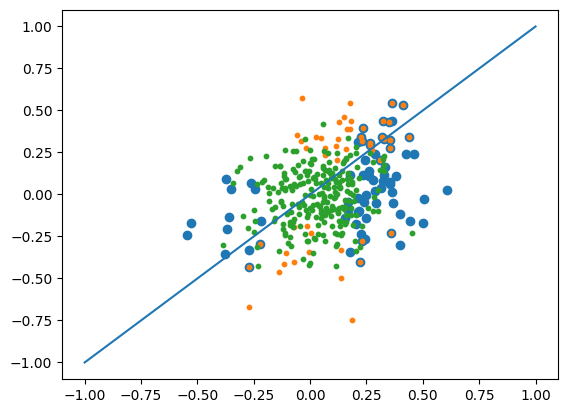

In [109]:
plt.scatter(np.array(r_in)[np.array(p_in)<0.05], np.array(r_out)[np.array(p_in)<0.05])
plt.scatter(np.array(r_in)[np.array(p_out)<0.05], np.array(r_out)[np.array(p_out)<0.05], s=10)
plt.scatter(np.array(r_in)[np.logical_and(np.array(p_out)>0.05, np.array(p_in)>0.05)], np.array(r_out)[np.logical_and(np.array(p_out)>0.05, np.array(p_in)>0.05)], s=10)
plt.plot([-1, 1], [-1,1])

In [ ]:
r_match_in=[]
p_match_in=[]

values=[11,15,51,55]
cells= range(len(test_lip_avg))

# 

for cell in tqdm(cells):
    # test_data=test_lip_avg[cell]
    rtcor=trial_latency(test_lip_avg[cell])
    r_match_in.append(rtcor[0])
    p_match_in.append(rtcor[1])


# r_match_in=np.array(r_match_in)
# p_match_in=np.array(p_match_in)

In [ ]:
plt.hist(np.array(r_match_in)[s])

In [ ]:
p_match_in

In [ ]:
print(lat[np.logical_and(lat>0, rts>0)])
print(rts[np.logical_and(lat>0, rts>0)])

In [ ]:
plt.scatter(lat, rts)
lat_sel=lat[np.logical_and(lat>0, rts>0)]
rts_sel=rts[lat>0]

r, p= stats.pearsonr(lat_sel, rts_sel)
print([r,p])

In [ ]:
rts     =   test_data['reaction times'][stim_match_in]

In [ ]:
test_data=test_lip_zsc[i]

test_datab=test_lip_avg[i]
values=[11,15,51,55]
for test in values:
    globals()['stim_vis_'+ str(test) +'_in']   =   basic_cond(test_data=test_data, sample_value=-1, test_value=test, position=1)
    globals()['stim_vis_'+ str(test)+'_out']  =   basic_cond(test_data=test_data, sample_value=-1, test_value=test, position=-1)
    for sample in values:
        globals()['s_in_'+str(sample)+'_t_'+ str(test)]  =   basic_cond(test_data=test_data, sample_value=sample, test_value=test, position=1)
        globals()['s_out_'+str(sample)+'_t_'+ str(test)] =   basic_cond(test_data=test_data, sample_value=sample, test_value=test, position=-1)

stim_match_1155_in      =   np.sort(np.concatenate([s_in_11_t_11, s_in_55_t_55]))
stim_nomatch_1155_in    =   np.sort(np.concatenate([s_in_15_t_11, s_in_51_t_11,s_in_55_t_11,
                                                    s_in_11_t_55, s_in_15_t_55,s_in_51_t_55]))

stim_match_1551_in     =   np.sort(np.concatenate([s_in_15_t_15, s_in_51_t_51]))
stim_nomatch_1551_in   =   np.sort(np.concatenate([s_in_11_t_15, s_in_51_t_15, s_in_55_t_15,
                                                s_in_11_t_51, s_in_15_t_51,s_in_55_t_51]))

stim_match_in    =   np.sort(np.concatenate([s_in_11_t_11, s_in_15_t_15, s_in_51_t_51, s_in_55_t_55]))
stim_nomatch_in  =   np.sort(np.concatenate([s_in_11_t_15, s_in_11_t_51,s_in_11_t_55,
                                            s_in_15_t_11, s_in_15_t_51,s_in_15_t_55,
                                            s_in_51_t_11, s_in_51_t_15,s_in_51_t_55,
                                            s_in_55_t_11, s_in_55_t_15,s_in_55_t_51]))

roc_vis_1155_zs_in, p_vis_1155_zs_in        =   compute_roc_auc(test_data['zscored data'][stim_vis_11_in, :], test_data['zscored data'][stim_vis_55_in, :])
roc_match_1155_zs_in, p_match_1155_zs_in    =   compute_roc_auc(test_data['zscored data'][stim_match_1155_in, :], test_data['zscored data'][stim_nomatch_1155_in, :])

roc_vis_1551_zs_in, p_vis_1551_zs_in        =   compute_roc_auc(test_data['zscored data'][stim_vis_15_in, :], test_data['zscored data'][stim_vis_51_in, :])
roc_match_1551_zs_in, p_match_1551_zs_in    =   compute_roc_auc(test_data['zscored data'][stim_match_1551_in, :], test_data['zscored data'][stim_nomatch_1551_in, :])

roc_match_zs_in, p_match_zs_in  =   compute_roc_auc(test_data['zscored data'][stim_match_in, :], test_data['zscored data'][stim_nomatch_in, :])

# OUT

stim_match_1155_out      =   np.sort(np.concatenate([s_out_11_t_11, s_out_55_t_55]))
stim_nomatch_1155_out    =   np.sort(np.concatenate([s_out_15_t_11, s_out_51_t_11,s_out_55_t_11,
                                                    s_out_11_t_55, s_out_15_t_55,s_out_51_t_55]))

stim_match_1551_out     =   np.sort(np.concatenate([s_out_15_t_15, s_out_51_t_51]))
stim_nomatch_1551_out   =   np.sort(np.concatenate([s_out_11_t_15, s_out_51_t_15, s_out_55_t_15,
                                                s_out_11_t_51, s_out_15_t_51,s_out_55_t_51]))

stim_match_out    =   np.sort(np.concatenate([s_out_11_t_11, s_out_15_t_15, s_out_51_t_51, s_out_55_t_55]))
stim_nomatch_out  =   np.sort(np.concatenate([s_out_11_t_15, s_out_11_t_51,s_out_11_t_55,
                                            s_out_15_t_11, s_out_15_t_51,s_out_15_t_55,
                                            s_out_51_t_11, s_out_51_t_15,s_out_51_t_55,
                                            s_out_55_t_11, s_out_55_t_15,s_out_55_t_51]))

roc_vis_1155_zs_out, p_vis_1155_zs_out        =   compute_roc_auc(test_data['zscored data'][stim_vis_11_out, :], test_data['zscored data'][stim_vis_55_out, :])
roc_match_1155_zs_out, p_match_1155_zs_out    =   compute_roc_auc(test_data['zscored data'][stim_match_1155_out, :], test_data['zscored data'][stim_nomatch_1155_out, :])

roc_vis_1551_zs_out, p_vis_1551_zs_out        =   compute_roc_auc(test_data['zscored data'][stim_vis_15_out, :], test_data['zscored data'][stim_vis_51_out, :])
roc_match_1551_zs_out, p_match_1551_zs_out    =   compute_roc_auc(test_data['zscored data'][stim_match_1551_out, :], test_data['zscored data'][stim_nomatch_1551_out, :])

roc_match_zs_out, p_match_zs_out  =   compute_roc_auc(test_data['zscored data'][stim_match_out, :], test_data['zscored data'][stim_nomatch_out, :])

# roc_in, pr_in      =   compute_roc_auc(test_data['zscored data'][stim_match_in, 300+50:300+250], test_data['zscored data'][stim_nomatch_in, 300+50:300+250])
# roc_out, pr_out    =   compute_roc_auc(test_data['zscored data'][stim_match_out, 300+50:300+250], test_data['zscored data'][stim_nomatch_out, 300+50:300+250])

# roc_match_in.append(roc_in)
# roc_match_out.append(roc_out)
# p_match_in.append(pr_in)
# p_match_out.append(pr_out)

acti    =   np.mean(test_data['zscored data'][stim_match_in,300+50:300+250], axis=1)
rts     =   test_data['reaction times'][stim_match_in]

r, p= stats.pearsonr(acti[rts>0], rts[rts>0])
# r_in.append(r)
# p_in.append(p)


acti    =   np.mean(test_data['zscored data'][stim_match_out,300+50:300+250], axis=1)
rts     =   test_data['reaction times'][stim_match_out]
r, p    =   stats.pearsonr(acti[rts>0], rts[rts>0])
# r_out.append(r)
# p_out.append(p)

In [ ]:

acti    =   test_data['zscored data'][stim_match_in,300+50:300+250]
rts     =   test_data['reaction times'][stim_match_in]

In [ ]:
rts

In [ ]:
r_in=np.array(r_in)
r_out=np.array(r_out)

p_in=np.array(p_in)
p_out=np.array(p_out)



insig=np.where(np.logical_and(p_in<0.05, p_out>0.05))
outsig=np.where(np.logical_and(p_in>0.05, p_out<0.05))
bothsig=np.where(np.logical_and(p_in<0.05, p_out<0.05))
bothnpnsig=np.where(np.logical_and(p_in>0.05, p_out>0.05))


roc_in=np.reshape(np.concatenate(roc_match_in), ([len(roc_match_in), roc_match_in[0].shape[0]]))
mroc_in=np.max(roc_in, 1)
roc_out=np.reshape(np.concatenate(roc_match_in), ([len(roc_match_in), roc_match_in[0].shape[0]]))
mroc_out=np.max(roc_in, 1)


plt.plot(mroc_in[np.concatenate([insig[0], bothsig[0]])], r_in[np.concatenate([insig[0], bothsig[0]])], 'or' )
plt.plot(mroc_in[np.concatenate([outsig[0], bothnpnsig[0]])],r_in[np.concatenate([outsig[0], bothnpnsig[0]])], 'ob' )
# plt.plot(mroc_in[bothsig],r_in[bothsig], 'og')
# plt.plot(mroc_in[bothnpnsig],r_in[bothnpnsig], 'ok')



In [ ]:
np.concatenate([insig[0], bothnpnsig[0]])

In [ ]:
acti=np.mean(test_data['zscored data'][stim_match_out,300+50:300+200], axis=1)

rts=test_data['reaction times'][stim_match_out]

In [ ]:
rtsnp.concatenate(insig, bothnpnsig)

In [ ]:
# acti=test_data['zscored data'][stim_match_in,300+50:300+200]
r, p=stats.pearsonr(acti[rts>0], rts[rts>0])
# plt.imshow(r)
# plt.colorbar()


In [ ]:
np.concatenate(insig, bothnpnsig)

In [ ]:
r

In [ ]:
acti=np.mean(test_data['zscored data'][stim_match_out,300+50:300+200], axis=1)

In [ ]:
acti

In [ ]:
test_data['zscored data'][stim_match_out,:]

In [ ]:
test_data

In [ ]:
rts.shape

In [ ]:
acti=np.mean(test_data['zscored data'][stim_match_in,300+50:300+200], axis=1)
acti.shape

In [ ]:
cp_coeff_in, cp_p_in=stats.pearsonr(rts, acti)


In [ ]:
rts=test_data['reaction times'][stim_match_in]
select_trials=stim_match_in[rts>0]
rts=test_data['reaction times'][select_trials]
acti=np.mean(test_data['zscored data'][select_trials,300+50:300+200], axis=1)
cp_coeff_in, cp_p_in=stats.pearsonr(rts, acti)

In [ ]:
win=np.arange(50,200)

In [ ]:
win

In [ ]:
win=np.arange(50,200)
rts=test_data['reaction times'][stim_match_in]
# select_trials=stim_match_in[rts>0]
# rts=test_data['reaction times'][select_trials]
acti=np.mean(test_data['zscored data'][stim_match_in,300+50:300+200], axis=1)
cp_coeff_in, cp_p_in=stats.pearsonr(rts[rts>0], acti[rts>0])

rts=test_data['reaction times'][stim_match_out]
# select_trials=stim_match_out[rts>0]
# rts=test_data['reaction times'][select_trials]
acti=np.mean(test_data['zscored data'][stim_match_out,300+50:300+200], axis=1)
cp_coeff_out, cp_p_out=stats.pearsonr(rts[rts>0], acti[rts>0])

In [ ]:
def ocm(test_data):
    if test_data is not None:
        values=[11,15,51,55]
            
        for test in values:
            globals()['stim_vis_'+ str(test) +'_in']   =   basic_cond(test_data=test_data, sample_value=-1, test_value=test, position=1)
            globals()['stim_vis_'+ str(test)+'_out']  =   basic_cond(test_data=test_data, sample_value=-1, test_value=test, position=-1)
            for sample in values:
                globals()['s_in_'+str(sample)+'_t_'+ str(test)]  =   basic_cond(test_data=test_data, sample_value=sample, test_value=test, position=1)
                globals()['s_out_'+str(sample)+'_t_'+ str(test)] =   basic_cond(test_data=test_data, sample_value=sample, test_value=test, position=-1)

        stim_match_1155_in      =   np.sort(np.concatenate([s_in_11_t_11, s_in_55_t_55]))
        stim_nomatch_1155_in    =   np.sort(np.concatenate([s_in_15_t_11, s_in_51_t_11,s_in_55_t_11, 
                                                            s_in_11_t_55, s_in_15_t_55,s_in_51_t_55]))

        stim_match_1551_in     =   np.sort(np.concatenate([s_in_15_t_15, s_in_51_t_51]))
        stim_nomatch_1551_in   =   np.sort(np.concatenate([s_in_11_t_15, s_in_51_t_15, s_in_55_t_15,
                                                        s_in_11_t_51, s_in_15_t_51,s_in_55_t_51]))

        stim_match_in    =   np.sort(np.concatenate([s_in_11_t_11, s_in_15_t_15, s_in_51_t_51, s_in_55_t_55]))
        stim_nomatch_in  =   np.sort(np.concatenate([s_in_11_t_15, s_in_11_t_51,s_in_11_t_55,
                                                    s_in_15_t_11, s_in_15_t_51,s_in_15_t_55,
                                                    s_in_51_t_11, s_in_51_t_15,s_in_51_t_55,
                                                    s_in_55_t_11, s_in_55_t_15,s_in_55_t_51]))

        roc_vis_1155_zs_in, p_vis_1155_zs_in        =   compute_roc_auc(test_data['zscored data'][stim_vis_11_in, :], test_data['zscored data'][stim_vis_55_in, :])
        roc_match_1155_zs_in, p_match_1155_zs_in    =   compute_roc_auc(test_data['zscored data'][stim_match_1155_in, :], test_data['zscored data'][stim_nomatch_1155_in, :])

        roc_vis_1551_zs_in, p_vis_1551_zs_in        =   compute_roc_auc(test_data['zscored data'][stim_vis_15_in, :], test_data['zscored data'][stim_vis_51_in, :])
        roc_match_1551_zs_in, p_match_1551_zs_in    =   compute_roc_auc(test_data['zscored data'][stim_match_1551_in, :], test_data['zscored data'][stim_nomatch_1551_in, :])

        roc_match_zs_in, p_match_zs_in  =   compute_roc_auc(test_data['zscored data'][stim_match_in, :], test_data['zscored data'][stim_nomatch_in, :])

        # OUT


        stim_match_1155_out      =   np.sort(np.concatenate([s_out_11_t_11, s_out_55_t_55]))
        stim_nomatch_1155_out    =   np.sort(np.concatenate([s_out_15_t_11, s_out_51_t_11,s_out_55_t_11, 
                                                            s_out_11_t_55, s_out_15_t_55,s_out_51_t_55]))

        stim_match_1551_out     =   np.sort(np.concatenate([s_out_15_t_15, s_out_51_t_51]))
        stim_nomatch_1551_out   =   np.sort(np.concatenate([s_out_11_t_15, s_out_51_t_15, s_out_55_t_15,
                                                        s_out_11_t_51, s_out_15_t_51,s_out_55_t_51]))

        stim_match_out    =   np.sort(np.concatenate([s_out_11_t_11, s_out_15_t_15, s_out_51_t_51, s_out_55_t_55]))
        stim_nomatch_out  =   np.sort(np.concatenate([s_out_11_t_15, s_out_11_t_51,s_out_11_t_55,
                                                    s_out_15_t_11, s_out_15_t_51,s_out_15_t_55,
                                                    s_out_51_t_11, s_out_51_t_15,s_out_51_t_55,
                                                    s_out_55_t_11, s_out_55_t_15,s_out_55_t_51]))
        roc_vis_1155_zs_out, p_vis_1155_zs_out        =   compute_roc_auc(test_data['zscored data'][stim_vis_11_out, :], test_data['zscored data'][stim_vis_55_out, :])
        roc_match_1155_zs_out, p_match_1155_zs_out    =   compute_roc_auc(test_data['zscored data'][stim_match_1155_out, :], test_data['zscored data'][stim_nomatch_1155_out, :])

        roc_vis_1551_zs_out, p_vis_1551_zs_out        =   compute_roc_auc(test_data['zscored data'][stim_vis_15_out, :], test_data['zscored data'][stim_vis_51_out, :])
        roc_match_1551_zs_out, p_match_1551_zs_out    =   compute_roc_auc(test_data['zscored data'][stim_match_1551_out, :], test_data['zscored data'][stim_nomatch_1551_out, :])
               
        roc_match_zs_out, p_match_zs_out  =   compute_roc_auc(test_data['zscored data'][stim_match_out, :], test_data['zscored data'][stim_nomatch_out, :])

        # zs_in=np.mean(np.mean(test_data['zscored data'][test_data['sample pos']==1,:], axis=0), axis=1)
        # zs_out=np.mean(np.mean(test_data['zscored data'][test_data['sample pos']==-1,:], axis=0), axis=1)

        
        ## choice probability
        rts=test_data['reaction times'][stim_match_in]
        select_trials=stim_match_in[rts>0]
        rts=test_data['reaction times'][select_trials]
        acti=np.mean(test_data['zscored data'][stim_match_in,300+50:300+200], axis=1)
        cp_coeff_in, cp_p_in=stats.pearsonr(rts, acti)

        rts=test_data['reaction times'][stim_match_out]
        select_trials=stim_match_out[rts>0]
        rts=test_data['reaction times'][select_trials]
        acti=np.mean(test_data['zscored data'][select_trials,300+50:300+200], axis=1)
        cp_coeff_out, cp_p_out=stats.pearsonr(rts, acti)

        ########for archive########
        # # test o1 vs o5
        # vis_to1_in     =   np.sort(np.concatenate([s_in_11_t_11, s_in_15_t_11, s_in_51_t_11, s_in_55_t_11,
        #                                             s_in_11_t_15, s_in_15_t_15, s_in_51_t_15, s_in_55_t_15]))

        # vis_to5_in     =   np.sort(np.concatenate([s_in_11_t_51, s_in_15_t_51, s_in_51_t_51, s_in_55_t_51,
        #                                         s_in_11_t_55, s_in_15_t_55, s_in_51_t_55, s_in_55_t_55]))

        # vis_tc1_in     =   np.sort(np.concatenate([s_in_11_t_11, s_in_15_t_11, s_in_51_t_11, s_in_55_t_11,
        #                                         s_in_11_t_51, s_in_15_t_51, s_in_51_t_51, s_in_55_t_51]))

        # vis_tc5_in     =   np.sort(np.concatenate([s_in_11_t_15, s_in_15_t_15, s_in_51_t_15, s_in_55_t_15,
        #                                         s_in_11_t_55, s_in_15_t_55, s_in_51_t_55, s_in_55_t_55]))

        # match_trials_in    =   np.sort(np.concatenate([s_in_11_t_11, s_in_15_t_15, s_in_51_t_51, s_in_55_t_51]))
        # nomatch_trials_in  =   np.sort(np.concatenate([s_in_11_t_15, s_in_11_t_51,s_in_11_t_55,
        #                                             s_in_15_t_11, s_in_15_t_51,s_in_11_t_55,
        #                                             s_in_51_t_11, s_in_51_t_15,s_in_51_t_55,
        #                                             s_in_55_t_11, s_in_55_t_15,s_in_55_t_51]))
        # o_test_av_in, p_o_test_av_in  =   compute_roc_auc(test_data['averaged data'][vis_to1_in, :], test_data['averaged data'][vis_to5_in, :])
        # c_test_av_in, p_c_test_av_in  =   compute_roc_auc(test_data['averaged data'][vis_tc1_in, :], test_data['averaged data'][vis_tc5_in, :])
        # m_test_av_in, p_m_test_av_in  =   compute_roc_auc(test_data['averaged data'][match_trials_in, :], test_data['averaged data'][nomatch_trials_in, :])

        # o_test_zs_in, p_o_test_zs_in  =   compute_roc_auc(test_data['zscored data'][vis_to1_in, :], test_data['zscored data'][vis_to5_in, :])
        # c_test_zs_in, p_c_test_zs_in  =   compute_roc_auc(test_data['zscored data'][vis_tc1_in, :], test_data['zscored data'][vis_tc5_in, :])
        # m_test_zs_in, p_m_test_zs_in  =   compute_roc_auc(test_data['zscored data'][match_trials_in, :], test_data['zscored data'][nomatch_trials_in, :])

        return{'name': test_data['name'],
                'reaction times': test_data['reaction times'],      
                'roc v vis in zs 1155'  :   roc_vis_1155_zs_in,
                'roc v vis in zs 1551'  :   roc_vis_1551_zs_in,
                'roc v match in zs 1155':   roc_match_1155_zs_in,
                'roc v match in zs 1551':   roc_match_1551_zs_in,
                'p v vis in zs 1155'    :   p_vis_1155_zs_in,
                'p v vis in zs 1551'    :   p_vis_1551_zs_in,
                'p v match in zs 1155'  :   p_match_1155_zs_in,
                'p v match in zs 1551'  :   p_match_1551_zs_in,
                'roc v match in zs'     :   roc_match_zs_in,
                'p v match in zs'       :   p_match_zs_in,
                'roc v vis out zs 1155'  :   roc_vis_1155_zs_out,
                'roc v vis out zs 1551'  :   roc_vis_1551_zs_out,
                'roc v match out zs 1155':   roc_match_1155_zs_out,
                'roc v match out zs 1551':   roc_match_1551_zs_out,
                'p v vis out zs 1155'    :   p_vis_1155_zs_out,
                'p v vis out zs 1551'    :   p_vis_1551_zs_out,
                'p v match out zs 1155'  :   p_match_1155_zs_out,
                'p v match out zs 1551'  :   p_match_1551_zs_out,
                'roc v match out zs'     :   roc_match_zs_out,
                'p v match out zs'       :   p_match_zs_out,
                'cp coeff in'       :   cp_coeff_in,
                'cp p in'           :   cp_p_in,
                'cp coeff out'      :   cp_coeff_out,
                'cp p out'          :   cp_p_out}

In [ ]:
def match_vis_plot(time,data,title, c1_match, c2_match, c1_nomatch, c2_nomatch, rt, min, max, ax):
    if any(c1_match):
        match_vis_plot=ax.plot(time, np.mean(data[c1_match, :650], axis=0)*1000, color='r', linewidth=2)

    if any(c2_match):
        match_vis_plot=ax.plot(time, np.mean(data[c2_match, :650], axis=0)*1000, color='b', linewidth=2)

    if any(c1_nomatch):
        match_vis_plot=ax.plot(time, np.mean(data[c1_nomatch, :650], axis=0)*1000, color='r', linestyle=(5, (5,2)), linewidth=2)
    if any(c2_nomatch):
        match_vis_plot=ax.plot(time, np.mean(data[c2_nomatch, :650], axis=0)*1000, color='b', linestyle=(5, (5,2)), linewidth=2)

    match_vis_plot=ax.plot([rt, rt], [min,max], 'k', linewidth=2)
    match_vis_plot=ax.plot([0,0], [min,max], color=[.5,.5,.5], linewidth=2)


    match_vis_plot=ax.spines['top'].set_visible(False)
    match_vis_plot=ax.spines['right'].set_visible(False)

    
    match_vis_plot=ax.tick_params(direction="in")
    match_vis_plot=ax.set_ylim([min, max])
    match_vis_plot=ax.set_title(title)

    return match_vis_plot

In [ ]:
def match_vis_roc_plot(time, r_match, r_vis, p_match, p_vis, rt, min, max, ax):
    if any(r_match):
        match_vis_plot=ax.plot(time, r_match[:650], color='k', linewidth=2)
    if any(r_vis):
        match_vis_plot=ax.plot(time, r_vis[:650], color=[.5,.5,.5], linewidth=2)
    
    match_vis_plot=ax.plot([rt, rt], [min,max], 'k', linewidth=2)
    match_vis_plot=ax.plot([0,0], [min,max], color=[.5,.5,.5], linewidth=2)


    if any(p_vis<0.01):
        match_vis_plot=ax.plot(time[np.where(p_vis[:600]<0.01)[0]], np.zeros(np.sum(p_vis[:600]<0.01))-0.7, color=[.5,.5,.5],marker='*')
    if any(p_match<0.01):
        match_vis_plot=ax.plot(time[np.where(p_match[:600]<0.01)[0]], np.zeros(np.sum(p_match[:600]<0.01))-0.9, color='k',marker='*')

    match_vis_plot=ax.spines['top'].set_visible(False)
    match_vis_plot=ax.spines['right'].set_visible(False)

    
    match_vis_plot=ax.tick_params(direction="in")
    match_vis_plot=ax.set_ylim([min, max])
    # match_vis_plot=ax.set_title(title)

    return match_vis_plot

In [ ]:
time=np.arange(650)-160/2
fig, ax=plt.subplots(4,4, figsize=(15,10), gridspec_kw={'height_ratios': [1.5, 1,1.5,1]})
fig.tight_layout()
ax[0,0]=match_vis_plot(time=   time,
                       data=test_data['averaged data'],
                       title='11 vs 55 IN',
                        c1_match=   s_in_o1c1_t_o1c1,
                        c2_match=   s_in_o5c5_t_o5c5,
                        c1_nomatch    =   np.concatenate([s_in_o1c5_t_o1c1, s_in_o5c1_t_o1c1, s_in_o5c5_t_o1c1]),
                        c2_nomatch    =   np.concatenate([s_in_o1c1_t_o5c5, s_in_o1c5_t_o5c5, s_in_o5c1_t_o5c5]),
                        rt            =   np.mean(test_data['reaction times']),
                        min           =   0,
                        max           =   (ma+ma/3)*1000,
                        ax=ax[0,0])

ax[1,0]=match_vis_roc_plot(time     =   time,
                            r_vis   =   roc_vis_1155_av_in,
                            r_match =   roc_match_1155_av_in,
                            p_vis   =   p_vis_1155_av_in,
                            p_match =   p_match_1155_av_in,
                            rt      =   np.mean(test_data['reaction times']),
                            min     =   -1,
                            max     =   1,
                            ax      =   ax[1,0])

ax[0,1]=match_vis_plot(time=   time,
                       data=test_data['averaged data'],
                       title='11 vs 55 OUT',
                        c1_match=   s_out_o1c1_t_o1c1,
                        c2_match=   s_out_o5c5_t_o5c5,
                        c1_nomatch    =   np.concatenate([s_out_o1c5_t_o1c1, s_out_o5c1_t_o1c1, s_out_o5c5_t_o1c1]),
                        c2_nomatch    =   np.concatenate([s_out_o1c1_t_o5c5, s_out_o1c5_t_o5c5, s_out_o5c1_t_o5c5]),
                        rt            =   np.mean(test_data['reaction times']),
                        min           =   0,
                        max           =   (ma+ma/3)*1000,
                        ax=ax[0,1])

ax[1,1]=match_vis_roc_plot(time     =   time,
                            r_vis   =   roc_vis_1155_av_out,
                            r_match =   roc_match_1155_av_out,
                            p_vis   =   p_vis_1155_av_out,
                            p_match =   p_match_1155_av_out,
                            rt      =   np.mean(test_data['reaction times']),
                            min     =   -1,
                            max     =   1,
                            ax      =   ax[1,1])

ax[2,0]=match_vis_plot(time=   time,
                       data=test_data['averaged data'],
                       title='15 vs 51 IN',
                        c1_match=   s_in_o1c5_t_o1c5,
                        c2_match=   s_in_o5c1_t_o5c1,
                        c1_nomatch    =   np.concatenate([s_in_o1c1_t_o1c5, s_in_o5c1_t_o1c5, s_in_o5c5_t_o1c5]),
                        c2_nomatch    =   np.concatenate([s_in_o1c1_t_o5c1, s_in_o1c5_t_o5c1, s_in_o5c5_t_o5c1]),
                        rt            =   np.mean(test_data['reaction times']),
                        min           =   0,
                        max           =   (ma+ma/3)*1000,
                        ax=ax[2,0])

ax[3,0]=match_vis_roc_plot(time     =   time,
                            r_vis   =   roc_vis_1551_av_in,
                            r_match =   roc_match_1551_av_in,
                            p_vis   =   p_vis_1551_av_in,
                            p_match =   p_match_1551_av_in,
                            rt      =   np.mean(test_data['reaction times']),
                            min     =   -1,
                            max     =   1,
                            ax      =   ax[3,0])
ax[2,1]=match_vis_plot(time=   time,
                       data=test_data['averaged data'],
                       title='15 vs 51 OUT',
                        c1_match=   s_out_o1c5_t_o1c5,
                        c2_match=   s_out_o5c1_t_o5c1,
                        c1_nomatch    =   np.concatenate([s_out_o1c1_t_o1c5, s_out_o5c1_t_o1c5, s_out_o5c5_t_o1c5]),
                        c2_nomatch    =   np.concatenate([s_out_o1c1_t_o5c1, s_out_o1c5_t_o5c1, s_out_o5c5_t_o5c1]),
                        rt            =   np.mean(test_data['reaction times']),
                        min           =   0,
                        max           =   (ma+ma/3)*1000,
                        ax=ax[2,1])


ax[3,1]=match_vis_roc_plot(time     =   time,
                            r_vis   =   roc_vis_1551_av_out,
                            r_match =   roc_match_1551_av_out,
                            p_vis   =   p_vis_1551_av_out,
                            p_match =   p_match_1551_av_out,
                            rt      =   np.mean(test_data['reaction times']),
                            min     =   -1,
                            max     =   1,
                            ax      =   ax[3,1])


ax[0,2]=match_vis_plot(time=   time,
                       data=test_data['averaged data'],
                       title='o1 vs o5 IN',
                        c1_match=   s_in_o1_t_o1,
                        c2_match=   s_in_o5_t_o5,
                        c1_nomatch    =   s_in_o5_t_o1,
                        c2_nomatch    =   s_in_o1_t_o5,
                        rt            =   np.mean(test_data['reaction times']),
                        min           =   0,
                        max           =   (ma+ma/3)*1000,
                        ax=ax[0,2])

ax[1,2]=match_vis_roc_plot(time     =   time,
                            r_vis   =   roc_vis_ori_av_in,
                            r_match =   roc_match_av_in,
                            p_vis   =   p_vis_ori_av_in,
                            p_match =   p_match_av_in,
                            rt      =   np.mean(test_data['reaction times']),
                            min     =   -1,
                            max     =   1,
                            ax      =   ax[1,2])



ax[0,3]=match_vis_plot(time=   time,
                       data=test_data['averaged data'],
                       title='c1 vs c5 IN',
                        c1_match=   s_in_c1_t_c1,
                        c2_match=   s_in_c5_t_c5,
                        c1_nomatch    =   s_in_c5_t_c1,
                        c2_nomatch    =   s_in_c1_t_c5,
                        rt            =   np.mean(test_data['reaction times']),
                        min           =   0,
                        max           =   (ma+ma/3)*1000,
                        ax=ax[0,3])

ax[1,3]=match_vis_roc_plot(time     =   time,
                            r_vis   =   roc_vis_col_av_in,
                            r_match =   roc_match_av_in,
                            p_vis   =   p_vis_col_av_in,
                            p_match =   p_match_av_in,
                            rt      =   np.mean(test_data['reaction times']),
                            min     =   -1,
                            max     =   1,
                            ax      =   ax[1,3])



                            

ax[2,3]=match_vis_plot(time=   time,
                       data=test_data['averaged data'],
                       title='match vs no match IN',
                        c1_match=   s_in_match,
                        c2_match=   [],
                        c1_nomatch    =   s_in_nomatch,
                        c2_nomatch    =   [],
                        rt            =   np.mean(test_data['reaction times']),
                        min           =   0,
                        max           =   (ma+ma/3)*1000,
                        ax=ax[2,3])

ax[3,3]=match_vis_roc_plot(time     =   time,
                            r_vis   =   roc_vis_col_av_in,
                            r_match =   roc_match_av_in,
                            p_vis   =   p_vis_col_av_in,
                            p_match =   p_match_av_in,
                            rt      =   np.mean(test_data['reaction times']),
                            min     =   -1,
                            max     =   1,
                            ax      =   ax[3,3])

In [ ]:
test_data['zscored data'][match_trials_in,rts-150:rts-50]

In [ ]:
# def reorganize_data(ocm_result):
name=[]
rt=[]
roc_1155_vis_in     =   []#np.empty([len(ocm_result), 800])
roc_1551_vis_in     =   []#np.empty([len(ocm_result), 800])
roc_1155_match_in   =   []#np.empty([len(ocm_result), 800])
roc_1551_match_in   =   []#np.empty([len(ocm_result), 800])
roc_match_in        =   []    

p_1155_vis_in       =   []#np.empty([len(ocm_result), 800])
p_1551_vis_in       =   []#np.empty([len(ocm_result), 800])
p_1155_match_in     =   []#np.empty([len(ocm_result), 800])
p_1551_match_in     =   []#np.empty([len(ocm_result), 800])
p_match_in          =   []    

roc_1155_vis_out    =   []#np.empty([len(ocm_result), 800])
roc_1551_vis_out    =   []#np.empty([len(ocm_result), 800])
roc_1155_match_out  =   []#np.empty([len(ocm_result), 800])
roc_1551_match_out  =   []#np.empty([len(ocm_result), 800])
roc_match_out       =   []    

p_1155_vis_out      =   []#np.empty([len(ocm_result), 800])
p_1551_vis_out      =   []#np.empty([len(ocm_result), 800])
p_1155_match_out    =   []#np.empty([len(ocm_result), 800])
p_1551_match_out    =   []#np.empty([len(ocm_result), 800])
p_match_out         =   []    


cp_coeff_in     =   []
cp_coeff_out    =   []
cp_p_in         =   []
cp_p_out        =   []

for i in range(len(ocm_result)):
    
    if ocm_result[i] is not None:  
        name.append(ocm_result[i]['name'])
        rt.append(ocm_result[i]['reaction times'])
        roc_1155_vis_in.append(ocm_result[i]['roc v vis in zs 1155'])
        roc_1155_match_in.append(ocm_result[i]['roc v match in zs 1155'])
        roc_1551_vis_in.append(ocm_result[i]['roc v vis in zs 1551'])
        roc_1551_match_in.append(ocm_result[i]['roc v match in zs 1551'])
        roc_match_in.append(ocm_result[i]['roc v match in zs'])

        p_1155_vis_in.append(ocm_result[i]['p v vis in zs 1155'])
        p_1155_match_in.append(ocm_result[i]['p v match in zs 1155'])
        p_1551_vis_in.append(ocm_result[i]['p v vis in zs 1551'])
        p_1551_match_in.append(ocm_result[i]['p v match in zs 1551'])
        p_match_in.append(ocm_result[i]['p v match in zs'])


        roc_1155_vis_out.append(ocm_result[i]['roc v vis out zs 1155'])
        roc_1155_match_out.append(ocm_result[i]['roc v match out zs 1155'])
        roc_1551_vis_out.append(ocm_result[i]['roc v vis out zs 1551'])
        roc_1551_match_out.append(ocm_result[i]['roc v match out zs 1551'])
        roc_match_out.append(ocm_result[i]['roc v match out zs'])

        p_1155_vis_out.append(ocm_result[i]['p v vis out zs 1155'])
        p_1155_match_out.append(ocm_result[i]['p v match out zs 1155'])
        p_1551_vis_out.append(ocm_result[i]['p v vis out zs 1551'])
        p_1551_match_out.append(ocm_result[i]['p v match out zs 1551'])
        p_match_out.append(ocm_result[i]['p v match out zs'])

        cp_coeff_in.append(ocm_result[i]['cp coeff in'])
        cp_coeff_out.append(ocm_result[i]['cp coeff out'])
        cp_p_in.append(ocm_result[i]['cp p in'])
        cp_p_out.append(ocm_result[i]['cp p out'])

roc_1155_vis_in=np.concatenate(roc_1155_vis_in)
roc_1155_vis_in=np.concatenate(roc_1155_vis_in)
roc_1155_match_in=np.concatenate(roc_1155_match_in)
roc_1155_match_in=np.concatenate(roc_1155_match_in)
roc_match_in=np.concatenate(roc_match_in)

p_1155_vis_in=np.concatenate(p_1155_vis_in)
p_1155_vis_in=np.concatenate(p_1155_vis_in)
p_1155_match_in=np.concatenate(p_1155_match_in)
p_1155_match_in=np.concatenate(p_1155_match_in)
p_match_in=np.concatenate(p_match_in)


roc_1155_vis_out=np.concatenate(roc_1155_vis_out)
roc_1155_vis_out=np.concatenate(roc_1155_vis_out)
roc_1155_match_out=np.concatenate(roc_1155_match_out)
roc_1155_match_out=np.concatenate(roc_1155_match_out)
roc_match_out=np.concatenate(roc_match_out)

p_1155_vis_out=np.concatenate(p_1155_vis_out)
p_1155_vis_out=np.concatenate(p_1155_vis_out)
p_1155_match_out=np.concatenate(p_1155_match_out)
p_1155_match_out=np.concatenate(p_1155_match_out)
p_match_out=np.concatenate(p_match_out)

cp_coeff_in=np.concatenate(cp_coeff_in)
cp_coeff_out=np.concatenate(cp_coeff_out)
cp_p_in=np.concatenate(cp_p_in)
cp_p_out=np.concatenate(cp_p_out)
rt=np.concatenate(rt)

# return {'name':name,
#         'reaction times': rt,
#         'roc v vis in 1155'     :   roc_1155_vis_in,
#         'roc v vis in 1551'     :   roc_1155_vis_in,
#         'roc v match in 1155'   :   roc_1155_match_in,
#         'roc v match in 1551'   :   roc_1155_match_in,
#         'roc v match in'        :   roc_match_in,
#         'p v vis in 1155'       :   p_1155_vis_in,
#         'p v vis in 1551'       :   p_1155_vis_in,
#         'p v match in 1155'     :   p_1155_match_in,
#         'p v match in 1551'     :   p_1155_match_in,
#         'p v match in'          :   p_match_in,
#         'roc v vis out 1155'    :   roc_1155_vis_out,
#         'roc v vis out 1551'    :   roc_1155_vis_out,
#         'roc v match out 1155'  :   roc_1155_match_out,
#         'roc v match out 1551'  :   roc_1155_match_out,
#         'roc v match out'       :   roc_match_out,
#         'p v vis out 1155'      :   p_1155_vis_out,
#         'p v vis out 1551'      :   p_1155_vis_out,
#         'p v match out 1155'    :   p_1155_match_out,
#         'p v match out 1551'    :   p_1155_match_out,
#         'p v match out'         :   p_match_out,
#         'cp coeff in'           :   cp_coeff_in,
#         'cp coeff out'          :   cp_coeff_out,
#         'cp p in'               :   cp_p_in,
#         'cp p out'              :   cp_p_out}

In [ ]:
ocm_result[1]['roc v vis in zs 1155'].shape

In [ ]:
cell=test_lip_zsc[20]
ocm_result=ocm(cell)

In [ ]:

numcells=2#len(test_lip_zsc)
# for i in tqdm(range(len(test_lip_zsc))):
    
#     tmp=ocm(test_lip_zsc[i])
ocm_result    =   Parallel(n_jobs = -1)(delayed(ocm)(cell) for cell in tqdm(test_lip_zsc[:numcells]))
# lip_avg_data, lip_ocm_data    =reorganize_data(ocm_result)

# with open('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/lip_roc_test', "wb") as fp: 
#     pickle.dump(lip_ocm_data, fp)

In [ ]:
len(ocm_result)

In [ ]:
ocm_result[0]['reaction times']

In [ ]:
lip_ocm_data    =reorganize_data(ocm_result)


In [ ]:
lip_ocm_data['reaction times'][0]

In [ ]:
#roc analyses
numcells=len(test_pfc)
ocm_result    =   Parallel(n_jobs = -1)(delayed(ocm)(cell) for cell in tqdm(test_pfc[:numcells]))
pfc_ocm_data=reorganize_data(ocm_result)


with open('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/pfc_roc_test', "wb") as fp: 
    pickle.dump(pfc_ocm_data, fp)
    

In [ ]:

numcells=len(test_v4)
ocm_result    =   Parallel(n_jobs = -1)(delayed(ocm)(cell) for cell in tqdm(test_v4[:numcells]))
v4_ocm_data=reorganize_data(ocm_result)
with open('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/v4_roc_test', "wb") as fp: 
    pickle.dump(v4_ocm_data, fp)

In [ ]:
# test_o1_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==1)]
# test_o2_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==2)]
# test_o3_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==3)]
# test_o4_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==4)]
# test_o5_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==5)]
# test_o6_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==6)]
# test_o7_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==7)]
# test_o8_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==8)]

# test_o1_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==1)]
# test_o2_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==2)]
# test_o3_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==3)]
# test_o4_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==4)]
# test_o5_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==5)]
# test_o6_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==6)]
# test_o7_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==7)]
# test_o8_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==8)]

# test_c1_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==1)]
# test_c2_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==2)]
# test_c3_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==3)]
# test_c4_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==4)]
# test_n_sc1_trials   =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==5)]
# test_c6_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==6)]
# test_c7_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==7)]
# test_c8_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==8)]

# test_c1_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==1)]
# test_c2_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==2)]
# test_c3_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==3)]
# test_c4_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==4)]
# test_c5_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==5)]
# test_c6_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==6)]
# test_c7_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==7)]
# test_c8_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==8)]

# test_o1_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==1)]
# test_o2_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==2)]
# test_o3_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==3)]
# test_o4_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==4)]
# test_o5_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==5)]
# test_o6_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==6)]
# test_o7_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==7)]
# test_o8_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==8)]

# test_c1_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==1)]
# test_c2_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==2)]
# test_c3_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==3)]
# test_c4_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==4)]
# test_c5_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==5)]
# test_c6_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==6)]
# test_c7_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==7)]
# test_c8_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==8)]

In [ ]:
# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_o1_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o2_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o3_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o4_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o5_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o6_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o7_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o8_so1_trials,250:450]*1000)], 'o')

# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_o1_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o2_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o3_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o4_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o5_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o6_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o7_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o8_so5_trials,250:450]*1000)], 'o')

# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_o1_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o2_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o3_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o4_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o5_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o6_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o7_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o8_sn_trials,250:450]*1000)], 'o')
# plt.legend(['o1 trials', 'o5 trials', 'neutral trials'])


In [ ]:
# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_c1_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c2_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c3_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c4_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c5_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c6_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c7_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c8_sc1_trials,250:450]*1000)], 'o')

# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_c1_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c2_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c3_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c4_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c5_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c6_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c7_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c8_sc5_trials,250:450]*1000)], 'o')

# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_c1_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c2_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c3_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c4_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c5_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c6_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c7_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c8_sn_trials,250:450]*1000)], 'o')
# plt.legend(['c1 trials', 'c5 trials', 'neutral trials'])


In [ ]:
# win=100
# step=1
# test_data_avg_sp, test_data_z_sp  =   moving_average(data=test_data,win=win, step=step)



In [ ]:
# plt.plot(np.mean(test_data_avg_sp[test_o1_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o2_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o3_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o4_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o5_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o6_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o7_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o8_so1_trials,:], axis=0)*1000)

In [ ]:
# plt.plot(np.mean(test_data_avg_sp[test_o1_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o2_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o3_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o4_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o5_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o6_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o7_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o8_so5_trials,:], axis=0)*1000)

In [ ]:
# so1c1_to1c1     =   np.where(np.logical_and(test_id==11, sample_id==11))[0]
# so1c5_to1c5     =   np.where(np.logical_and(test_id==15, sample_id==15))[0]
# so5c1_to5c1     =   np.where(np.logical_and(test_id==51, sample_id==51))[0]
# so5c5_to5c5     =   np.where(np.logical_and(test_id==55, sample_id==55))[0]

# sother_to1c1     =   np.where(np.logical_and(test_id==11, sample_id!=11, sample_id!=0))[0]
# sother_to1c5     =   np.where(np.logical_and(test_id==15, sample_id!=15, sample_id!=0))[0]
# sother_to5c1     =   np.where(np.logical_and(test_id==51, sample_id!=51, sample_id!=0))[0]
# sother_to5c5     =   np.where(np.logical_and(test_id==55, sample_id!=55, sample_id!=0))[0]


In [ ]:

plt.plot(np.mean(test_data_avg_sp[so1c1_to1c1,:], axis=0)*1000, color='c')
plt.plot(np.mean(test_data_avg_sp[so1c5_to1c5,:], axis=0)*1000, color='m')
plt.plot(np.mean(test_data_avg_sp[so5c1_to5c1,:], axis=0)*1000, color='y')
plt.plot(np.mean(test_data_avg_sp[so5c5_to5c5,:], axis=0)*1000, color='k')

plt.plot(np.mean(test_data_avg_sp[sother_to1c1,:], axis=0)*1000, color='c', linestyle='dashed')
plt.plot(np.mean(test_data_avg_sp[sother_to1c5,:], axis=0)*1000, color='m', linestyle='dashed')
plt.plot(np.mean(test_data_avg_sp[sother_to5c1,:], axis=0)*1000, color='y', linestyle='dashed')
plt.plot(np.mean(test_data_avg_sp[sother_to5c5,:], axis=0)*1000, color='k', linestyle='dashed')
